# Three investigators - part 4

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part 4: Data cleaning and analysis

- data cleaning and preparing for analysis
- explorative analysis of data
- saving output files for data visualisations in datawrapper

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [2]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date
import matplotlib.pyplot as plt

# for file directories
import os

%matplotlib inline

In [3]:
#change directory to root folder
os.chdir("..")

# Load data

In [4]:
#load scraped datafiles
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
content = pd.read_csv(".\\data\\scraped\\content.csv")
rating = pd.read_csv(".\\data\\scraped\\ratings.csv")

#load cleaned actors
actors = pd.read_csv(".\\data\\processed\\actors_cleaned_2020-11-23.csv")

#load title analysis
title_cat = pd.read_csv(".\\data\\processed\\title_categories_2020-11-23.csv")

#load actor gender prediction
gender = pd.read_csv(".\\data\\processed\\actor_gender_prediction_2020-11-23.csv")

In [5]:
print("meta:", meta.shape, "actors:" , actors.shape, "content:", content.shape, "rating:", rating.shape)

meta: (206, 33) actors: (2873, 8) content: (207, 2) rating: (239, 6)


# Data cleaning and prep

## Actors

### Remove episode 29 and duplicates

In [6]:
## remove 29 from actors table as it is music only
actors = actors.loc[actors["id"] != 29]

### Remove duplicates from actors table
actors = actors.drop_duplicates()

### Rename roles

In [7]:
#replace values
actors["role"] = actors["role"].str.replace("Mrs ", "Mrs. ").str.replace("Mr ", "Mr. ")
actors.loc[actors["role"].str.contains("Justus Jonas"), "role"] = 'Justus Jonas'
actors.loc[actors["role"].str.contains("ERZÄHLER"), "role"] = 'Erzähler'
actors.loc[actors["role"].str.contains("Peter Shaw"), "role"] = 'Peter Shaw'
actors.loc[actors["role"].str.contains("Bob Andrews"), "role"] = 'Bob Andrews'
actors.loc[actors["role"].str.contains("Hitchcock"), "role"] = 'Hitchcock'
actors.loc[actors["role"].str.contains("Mathilda"), "role"] = 'Tante Mathilda'
actors.loc[actors["role"].str.contains("Titus"), "role"] = 'Onkel Titus'
actors.loc[actors["role"].str.contains("Reynolds"), "role"] = 'Kommissar Reynolds'
actors.loc[actors["role"].str.contains("Skinny"), "role"] = 'Skinny Norris'
actors.loc[actors["role"].str.contains("Godween"), "role"] = 'Goodween'
#actors.loc[actors["role"].str.contains("Mr Shaw"), "role"] = 'Mr. Shaw'
actors.loc[actors["role"].str.contains("Herr Andrews"), "role"] = 'Mr. Andrews'
actors.loc[actors["role"].str.contains("Morton"), "role"] = 'Morton'
actors.loc[actors["role"].str.contains("Inspektor Cottahol"), "role"] = 'Inspektor Cotta'
actors.loc[actors["role"].str.contains("Cotta, Polizeiinspektor"), "role"] = 'Inspektor Cotta'
actors.loc[actors["role"].str.contains("Hugenay"), "role"] = 'Hugenay'
actors.loc[actors["role"].str.contains("Jelena"), "role"] = 'Jelena'

#create filter for main actor
actors["main_actor"] = 0
actors.loc[(actors["role"]=='Justus Jonas') | (actors["role"]=='Peter Shaw') | (actors["role"]=='Bob Andrews'), "main_actor"] = 1

#create filter for narrator
actors["narrator"] = 0
actors.loc[(actors["role"]=='Hitchcock') | (actors["role"]==u'Erzähler'), "narrator"] = 1

actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0


### add gender predictions

In [8]:
# join gender predictions to actors table
actors = pd.merge(actors, gender, left_on='firstname', right_on = "name", how="left")
actors = actors.drop("name", axis=1)
actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator,gender,gender_probability,gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,male,0.99,101928


In [9]:
# get list of names that have not been classified with a gender
actors.loc[actors["gender"].isna()]["firstname"].unique()

array(['Heikedine', 'Reinhilt', 'H.', 'Schiffmeister', '...', 'Rosakutty',
       'Gustav-Adolph', 'Rhesi', 'é', 'Jörgpeter'], dtype=object)

In [10]:
## classify gender of missing ones (if known)
actors.loc[actors["firstname"] == 'Heikedine', "gender"] = "female"
actors.loc[actors["firstname"] == 'Reinhilt', "gender"] = "female"
actors.loc[actors["firstname"] == 'Gustav-Adolph', "gender"] = "male"
actors.loc[actors["firstname"] == 'Jörgpeter', "gender"] = "male"
actors.loc[actors["firstname"] == 'Rhesi', "gender"] = "female"
actors.loc[actors["firstname"] == 'é', "gender"] = "male"

## Meta data

### Derive additional variables

In [11]:
#add book, cover, music, director, editor and sound columns
meta = meta.reindex(meta.columns.tolist() + ["book", 'cover', "music", "director", "editor", "sounds"], axis=1) 
def combine_col(df, new_col, columns):  #define function to combine columns
    df[new_col] = df[columns].apply(lambda x: "-".join(x.dropna().str.encode("utf8").astype(str)), axis=1)
combine_col(meta, ["book"], ["buch", "buch und effekte", "buch und redaktion", 
                             u"hörspielbearbeitung", "effekte und redaktion"] ) 
combine_col(meta, ["cover"], ["cover-illustration", "coverillustration"]) 
combine_col(meta, ["music"], ["musik", "musik und effekte"]) 
combine_col(meta, ["director"], ["regie", "produktion und regie", "regie und produktion"]) 
combine_col(meta, ["editor"], ["redaktion", u"redaktion und geräusche"]) 
combine_col(meta, ["sounds"],[ u'geräusche', u'ger�usche']) 

#convert date column
meta["date"] = pd.to_datetime(meta["erscheinungsdatum"], format='%d.%m.%Y')

## Create year and month column
meta["year"] = pd.DatetimeIndex(meta["date"]).year
meta["month"] = pd.DatetimeIndex(meta["date"]).month

# Extract minutes and return mean and total minutes by episode (mean = total for episodes with only 1 part)
meta["minutes"] = meta["laufzeit"].apply(lambda x: re.search("ca.(.*?)in", x).group(1))
meta["minutes"] = meta["minutes"].str.replace("M", "").str.replace("m", "").str.replace(" ", "").str.split("+")
meta["minutes"] = [[int(x) for x in sublist] for sublist in meta["minutes"]]
meta["minutes_mean"] = meta["minutes"].apply(lambda x: sum(x)/len(x))
meta["minutes_total"] = meta["minutes"].apply(lambda x: sum(x))

#calculate how many parts the episode has by using the sets of minutes given
meta["parts"] = meta["minutes"].apply(lambda x: len(x)) 

In [12]:
### add episode 29 details to meta table (https://www.rocky-beach.com/hoerspiel/folgen/029.html)
meta = meta.append({'id' : 29, 'music': 'B. Brac/B. George', 'date':'1982-03-21', 
                     'minutes': '34', 'minutes_mean':34, 'minutes_total':34, 'parts':1} , ignore_index=True)

### Add number of actors, main and side

In [13]:
actors_agg = pd.DataFrame(actors.groupby("id")[["actor", "main_actor", "narrator"]].agg(
    {"actor": "count", "main_actor":"sum", "narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"actor":"no_actors_total", "main_actor":"no_main_actors"})
actors_agg["no_side_actors"] = actors_agg["no_actors_total"] - actors_agg["no_main_actors"] - actors_agg["narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="id" ,right_on="id", how='left')

### Gender balance all actors

In [15]:
actors_gender = actors.groupby(["id", "gender"])["role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("id")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "id", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="id" ,right_on="id", how='left')

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta[["no_female_actors", "no_male_actors"]].sum(axis=1) *100

### Gender balance side actors

In [17]:
filter_side_actors = (actors["narrator"] == 0) & (actors["main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["id", "gender"])["role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("id")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "id", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="id" ,right_on="id", how='left')

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta[["no_female_side_actors", "no_male_side_actors"]].sum(axis=1) *100

### Narrator

In [19]:
narrator = actors.loc[actors["narrator"]==1][["id","actor_clean"]]
narrator = narrator.rename(columns={"actor_clean": "narrator_name"})

#join with meta
meta = pd.merge(meta, narrator, left_on="id" ,right_on="id", how='left')

### Author

In [20]:
#replace 'Erzählt von Kari Erlhoff' with 'Kari Erlhoff'
meta["erzählt von"] = meta["erzählt von"].str.replace('Erzählt von Kari Erlhoff', 'Kari Erlhoff')

# group authors
meta["author_grouped"] = meta["erzählt von"]

# group those authors with fewer than 5 episodes under 'other'
other_storytellers = pd.DataFrame(meta["erzählt von"].value_counts()).reset_index()
other_storytellers = other_storytellers.loc[other_storytellers["erzählt von"] < 5]["index"].tolist()
meta.loc[meta["erzählt von"].isin(other_storytellers), "author_grouped"] = "Other"

#display values
meta["author_grouped"].value_counts()

André Marx                           33
Marco Sonnleitner                    32
Ben Nevis                            22
Other                                18
Brigitte Johanna Henkel-Waidhofer    16
M.V. Carey                           15
William Arden                        14
Kari Erlhoff                         13
André Minninger                      12
Robert Arthur                        10
Astrid Vollenbruch                    7
Christoph Dittert                     7
Hendrik Buchna                        6
Name: author_grouped, dtype: int64

In [21]:
# create gender variable
author_gender_map = {'Robert Arthur': "male", 'William Arden': "male", 'M.V. Carey':"female",
                     'Nick West':"male", 'Marc Brandel':"male", 'Rose Estes':"female", 
                     'Megan Stine / H. William Stine': np.nan,
                   'G.H. Stone':"female", 'William McCay' : "male", 'Peter Lerangis' : "male",
                   'Brigitte Johanna Henkel-Waidhofer' : "female", 'André Marx' : "male",
                    'André Minninger' : "male", 'Ben Nevis': "male", 'Katharina Fischer': "female",
                   'Marco Sonnleitner' :"male", 'Astrid Vollenbruch': "female", 'Kari Erlhoff' : "female",
                  'Hendrik Buchna': "male", 'Christoph Dittert':"male"}

meta["author_gender"] = meta["erzählt von"].map(author_gender_map)

### merge rating

In [22]:
#rename columns in rating table
rating = rating.rename(columns={"bewertung.1" : "rating", "rang": "rating_rank", "ranking": "no_votes"})

#join with meta table
meta = pd.merge(meta, rating, left_on="id" ,right_on="id", how='left')

### title

In [23]:
# merge title categories into meta data
meta = meta.merge(title_cat, left_on="id", right_on="id", how='left' )

In [24]:
# clean up title

## make titles lower case
meta["title"] = meta["titel"].str.lower()

meta["title"] = meta["title"].str.replace("hörspiel", "", regex=True).str.replace("[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]", "", regex=True)

### Create column for number of episode published in each year

In [25]:
numbered = []

for i in range(len(meta["year"])): 
    if i == 0:
        x = 1
    elif meta["year"][i] == meta["year"][i-1]:
        x +=1
    else:
        x = 1
    numbered.append(x)
    
meta["no_per_year"] = numbered

### save output

In [26]:
### order by id and reset index
meta = meta.sort_values("id").reset_index(drop=True)

### save output
meta.to_csv(".\\data\\processed\\meta_for_analysis_" + "%s" %(str(date.today())) + ".csv", index=False) 

# Blog sections and exports for charts

## Chronology

In [28]:
chrono = meta[["id", "year", "no_per_year", "minutes_mean", "parts","title", "erzählt von", "rating"]]
chrono[["minutes_mean"]] = chrono[["minutes_mean"]].round(0)
chrono[["rating"]] = chrono[["rating"]].round(1)
chrono.to_csv(".\\data\\charts\\chrono-datawrapper.csv", index=False)

C:\Users\lisa.hornung\Anaconda2\envs\py3_dreif\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Roles

In [29]:
roles_filter = ["Justus Jonas", "Peter Shaw", "Bob Andrews","Hitchcock", "Erzähler", 
             "Inspektor Cotta", "Tante Mathilda", "Onkel Titus", "Morton", 
             "Kommissar Reynolds", "Goodween", "Mr. Andrews","Skinny Norris",
             "Kelly",  "Mrs. Shaw","Patrick", "Mr. Shaw", "Mrs. Andrews",  "Lys", "Rubbish George",
               "Patrick Kenneth", "Hugenay", "Jelena"]

roles_id = [len(roles_filter) - i for i in range(len(roles_filter))]

#create dataframe that only holds the roles we are interested in
roles = actors.loc[actors["role"].isin(roles_filter)]

#create column that includes role id
roles["role_id"] = roles["role"].replace(to_replace=roles_filter,value=roles_id)

# save as csv
roles[["role", "id", "role_id"]].to_csv(".\\data\\charts\\roles-by-episode-with-role-id.csv", index=False)

roles[["role", "id", "role_id"]]

C:\Users\lisa.hornung\Anaconda2\envs\py3_dreif\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,role,id,role_id
0,Hitchcock,1,20
1,Justus Jonas,1,23
2,Peter Shaw,1,22
3,Bob Andrews,1,21
10,Hugenay,1,2
...,...,...,...
2818,Inspektor Cotta,206,18
2822,Erzähler,207,19
2823,Justus Jonas,207,23
2824,Peter Shaw,207,22


In [30]:
roles_agg = roles.groupby("role")["id"].count().sort_values(ascending = False)

# save as csv
roles_agg.to_csv(".\\data\\charts\\roles-by-appearance.csv")

roles_agg

C:\Users\lisa.hornung\Anaconda2\envs\py3_dreif\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


role
Bob Andrews           206
Justus Jonas          206
Peter Shaw            206
Erzähler              131
Hitchcock              75
Inspektor Cotta        67
Tante Mathilda         55
Onkel Titus            35
Morton                 24
Kommissar Reynolds     22
Goodween               17
Mr. Andrews            15
Skinny Norris          12
Kelly                   9
Mrs. Shaw               6
Patrick                 6
Mrs. Andrews            5
Mr. Shaw                5
Lys                     5
Jelena                  5
Hugenay                 5
Patrick Kenneth         4
Rubbish George          4
Name: id, dtype: int64

# Explorative Analysis

## Chronology

In [26]:
years = meta.groupby("year")[["parts", "minutes_mean", "id"]].agg({
    "parts": ["sum"], "minutes_mean" : ["mean", "min", "max"], "id": ["count","min", "max"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"minutes_mean_mean": "minutes_mean",
                              "minutes_mean_min": "minutes_min", "minutes_mean_max":"minutes_max"}) 
years.head()

,year,parts_sum,minutes_mean,minutes_min,minutes_max,id_count,id_min,id_max
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,3,39.333333,34.0,44.0,3,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


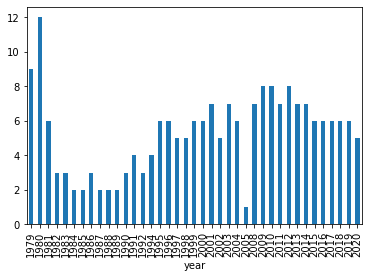

In [27]:
#number of episodes over time
meta.groupby("year")["id"].count().plot(kind='bar')

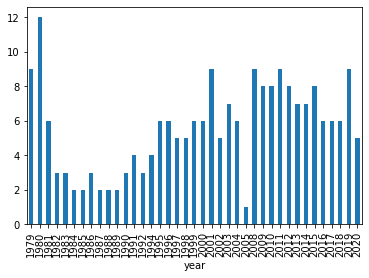

In [28]:
#number of episodes over time
years.set_index("year")["parts_sum"].plot(kind='bar')

### Length

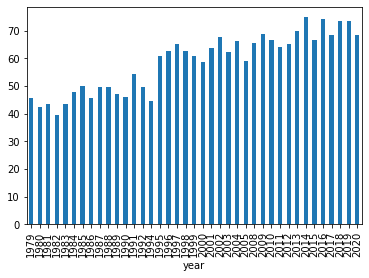

In [29]:
#Average length over time
meta.groupby("year")["minutes_mean"].mean().plot(kind='bar')

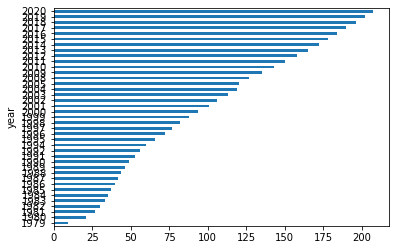

In [30]:
#number of episodes over time
years.set_index("year")["id_max"].plot(kind='barh')

### dotplot

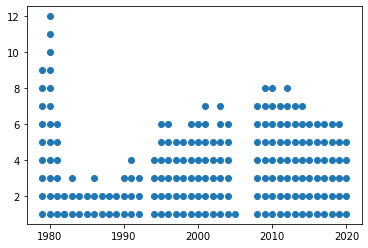

In [31]:
x = meta["year"]
y = meta["no_per_year"]
z = meta["parts"]

plt.scatter(x, y)

### Month

October is the most popular release month but mainly because of the first two years when 15 episodes were released in October.

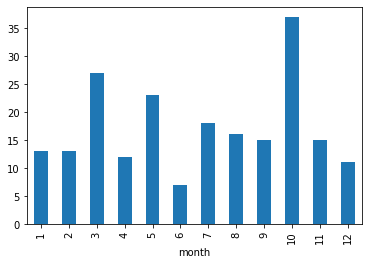

In [32]:
meta.groupby("month")["id"].count().plot(kind='bar')

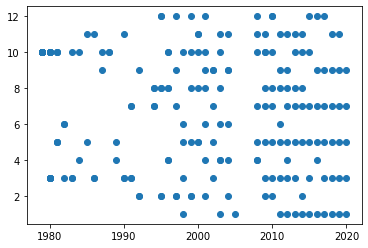

In [33]:
x = meta["year"]
y = meta["month"]

plt.scatter(x, y)

In [34]:
meta.groupby(["year", "month"])["id"].count()

year  month
1979  10       9
1980  3        6
      10       6
1981  5        3
      10       3
              ..
2020  1        1
      3        1
      5        1
      7        1
      9        1
Name: id, Length: 159, dtype: int64

## Author

In [35]:
meta["minutes_mean"].dtype

dtype('float64')

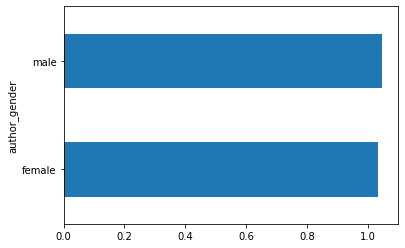

In [36]:
meta.groupby("author_gender")["parts"].mean().plot(kind='barh')

## Roles

## Gender

In [ ]:
#number of episodes over time
meta.set_index("id")["female_actors_ratio"].plot(kind='bar')

In [ ]:
x = meta["year"]
y = meta["female_side_actors_ratio"]

plt.scatter(x, y)

In [ ]:
meta.groupby("year")["female_side_actors_ratio"].max().plot(kind='bar')

In [ ]:
meta.groupby("author_grouped")["female_side_actors_ratio"].mean().plot(kind='bar')

In [ ]:
meta.groupby("author_grouped")["female_side_actors_ratio"].min().sort_values(ascending=False).plot(kind='bar')

## titles

In [ ]:
meta.groupby("year")["title_colour"].count().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_colour"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_sport"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_ethnic"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_place"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_tech"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_animal"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_mystery"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_paranormal"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_death"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_person"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_danger"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_fire"].sum().plot(kind='bar')

In [ ]:
meta.groupby("year")["title_treasure"].sum().plot(kind='bar')

## Rating

In [ ]:
rating.columns

In [ ]:
#number of episodes over time
meta.set_index("id")["rating"].plot(kind='bar')

In [ ]:
x = meta["year"]
y = meta["rating"]

plt.scatter(x, y)

In [ ]:
meta.shape

In [ ]:
x = meta["minutes"]
y = meta["rating"]

plt.scatter(x, y)

In [ ]:
meta.columns

### Author

In [ ]:
meta.groupby("erzählt von")["rating"].count().sort_values().plot(kind='bar')

In [ ]:
meta.groupby("author_grouped")["rating"].mean().sort_values(ascending=False).plot(kind='bar')

In [ ]:
meta.groupby("author_gender")["rating"].mean().plot(kind='bar')

### Actors

In [ ]:
x = meta["female_side_actors_ratio"]
y = meta["rating"]

plt.scatter(x, y)

### Topic

Seems like sport and tech themes have slightly lower ratings

In [ ]:
meta.groupby("title_sport")["rating"].mean().plot(kind='bar')

In [ ]:
meta.groupby("title_tech")["rating"].mean().plot(kind='bar')

In [ ]:
list(title_cat)